# Week 10.3.1 Topic Modelling using LDA

## Preparation

In this exercise, we will need to make sure the following packages are installed into your conda environment that runs this Jupyter notebook. 

`pip install gensim spacy pyLDAvis matplotlib numpy pandas`

To view the list of modules or packages installed, use

`conda list`

Then install the ones you do not have. Once installed, we can then import them and be prepared for the rest of the exercise. 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Define stop words

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
pprint(stop_words)

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Import the GSWA dataset

The 20-Newsgroups dataset contains about 6k data posts from 1,135 GSWA reports. 

The dataset can be imported using `pandas.read_json` and we can see the dataset has 3 columns. The `target-name` is the category or topics that the news is manually assigned to. 

We choose to use this dataset because it has pre-assigned categories according to topics, so our clustering results can be readily compared. In real world data, this is not always easily available. 

In [3]:
import zipfile
import json
# Import Dataset

data = list()
with zipfile.ZipFile("./data/wamex_xml.zip", "r") as z:
    #df = [pd.read_json(filename) for filename in z.namelist()]
    print(len(z.namelist()))
    for filename in z.namelist():
        # print(filename)
        # df = pd.read_json(filename)
        with z.open(filename) as f:
            # load the json file
            # The resulting `content` is a list
            content = json.loads(f.read()) 
            # Convert content to a string   
            content = "".join(content)
            # Add to the data list
            data.append(content)
            

#data.pop(0)
pprint(data[:1])

1135
['Combined Reporting Application Pending Status: Sheet 1:250 000: Kalgoorlie '
 '(SH 51-09) Sheet 1:100 000: Kalgoorlie (3136) Project Operator: Cazaly '
 'Resources Limited Author: M Watts Date: September 2006 Distribution: '
 '1.Department of Industry and Resources 2.Cazaly Resources Limited Cazaly '
 'Resources Limited September 2006 2 Figure 2: Castle Hill Project Tenement '
 'Location Plan, 1: 75 000 scale 6 Figure 3: Regional Geology with Exploration '
 'Index Map, 1:75 000 scale 8Cazaly Resources Limited September 2006 3 1.0 '
 'SUMMARY The Combined Mineral Exploration Report on the Castle Hill Project '
 'details exploration activities undertaken by Cazaly Resources Limited during '
 'the reporting period from 7 July 2005 to 6 July 2006.The reporting group '
 'known as Castle Hill comprises nine granted prospecting licences.The project '
 'area covers some 1250 hectares.Cazaly is the registered holder of the Castle '
 'Hill Project tenements.Cazalys exploration activities 

## Pre-processing
### Removing emails and newline characters

We can use regular expressions for this purpose by untilising the `re` package.

In [4]:
# Remove Figure No. 
data = [re.sub('Figure\s+\d+', '', sent) for sent in data]

# Remove all numbers
data = [re.sub('\d+', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Combined Reporting Application Pending Status: Sheet : : Kalgoorlie (SH -) '
 'Sheet : : Kalgoorlie () Project Operator: Cazaly Resources Limited Author: M '
 'Watts Date: September Distribution: .Department of Industry and Resources '
 '.Cazaly Resources Limited Cazaly Resources Limited September : Castle Hill '
 'Project Tenement Location Plan, : scale : Regional Geology with Exploration '
 'Index Map, : scale Cazaly Resources Limited September . SUMMARY The Combined '
 'Mineral Exploration Report on the Castle Hill Project details exploration '
 'activities undertaken by Cazaly Resources Limited during the reporting '
 'period from July to July .The reporting group known as Castle Hill comprises '
 'nine granted prospecting licences.The project area covers some '
 'hectares.Cazaly is the registered holder of the Castle Hill Project '
 'tenements.Cazalys exploration activities during the reporting period have '
 'been directed towards the acquisition of available reports and datase

### Tokenisation

We need to break down each sentence into a list of words, for the data to be ready for consumption by `gensim`. The `simple_preprocess()` function is built for such purposes. We can also set the `deacc=True` to remove punctuations. 

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['combined', 'reporting', 'application', 'pending', 'status', 'sheet', 'kalgoorlie', 'sh', 'sheet', 'kalgoorlie', 'project', 'operator', 'cazaly', 'resources', 'limited', 'author', 'watts', 'date', 'september', 'distribution', 'department', 'of', 'industry', 'and', 'resources', 'cazaly', 'resources', 'limited', 'cazaly', 'resources', 'limited', 'september', 'castle', 'hill', 'project', 'tenement', 'location', 'plan', 'scale', 'regional', 'geology', 'with', 'exploration', 'index', 'map', 'scale', 'cazaly', 'resources', 'limited', 'september', 'summary', 'the', 'combined', 'mineral', 'exploration', 'report', 'on', 'the', 'castle', 'hill', 'project', 'details', 'exploration', 'activities', 'undertaken', 'by', 'cazaly', 'resources', 'limited', 'during', 'the', 'reporting', 'period', 'from', 'july', 'to', 'july', 'the', 'reporting', 'group', 'known', 'as', 'castle', 'hill', 'comprises', 'nine', 'granted', 'prospecting', 'licences', 'the', 'project', 'area', 'covers', 'some', 'hectares', 'c

### Creating bigram and trigrams - Gensim’s Phrases model

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/ubuntu/anaconda3/envs/py3.7/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['combined_reporting', 'application', 'pending', 'status', 'sheet', 'kalgoorlie', 'sh', 'sheet', 'kalgoorlie', 'project', 'operator', 'cazaly', 'resources', 'limited', 'author', 'watts', 'date', 'september', 'distribution', 'department', 'of', 'industry', 'and', 'resources', 'cazaly', 'resources', 'limited', 'cazaly', 'resources', 'limited', 'september', 'castle_hill', 'project', 'tenement', 'location', 'plan', 'scale', 'regional', 'geology', 'with', 'exploration', 'index_map', 'scale', 'cazaly', 'resources', 'limited', 'september', 'summary', 'the', 'combined', 'mineral', 'exploration', 'report', 'on', 'the', 'castle_hill', 'project', 'details', 'exploration', 'activities', 'undertaken', 'by', 'cazaly', 'resources', 'limited', 'during', 'the', 'reporting_period', 'from', 'july', 'to', 'july', 'the', 'reporting', 'group', 'known', 'as', 'castle_hill', 'comprises', 'nine', 'granted_prospecting_licences', 'the', 'project', 'area', 'covers', 'some', 'hectares_cazaly', 'is', 'the', 'regist

### Build functions for the pre-processing pipeline

Remove stopwords, make bigram and trigrams, and lemmatisation.

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Call the functions in order

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

#### Caution on the lemmatiser

During the processing of the data, we realised that some documents is empty. We also know that the lemmatiser has a restriction on processing text no longer than 1000000 characters. So let's filter those documents out. 

In [9]:
index = 0
print(len(data_words_bigrams))

for text in data_words_bigrams:
    doc = " ".join(text)
    #print(len(doc))
    if(len(doc)==0 or len(doc)>1000000):
        data_words_bigrams.pop(index)
        
    index += 1
    
print(len(data_words_bigrams))


1135
934


In [10]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en


nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['combine', 'reporting', 'application', 'pend', 'status', 'sheet', 'kalgoorlie', 'sheet', 'kalgoorlie', 'project', 'operator', 'cazaly', 'resource', 'limited', 'author', 'watt', 'date', 'september', 'distribution', 'department', 'industry', 'resource', 'cazaly', 'resource', 'limit', 'cazaly', 'resource', 'limit', 'september', 'castle_hill', 'project', 'tenement', 'location', 'plan', 'scale', 'regional', 'geology', 'exploration', 'index_map', 'scale', 'cazaly', 'resource', 'limit', 'september', 'summary', 'combine', 'mineral', 'exploration', 'report', 'castle_hill', 'project', 'detail', 'exploration', 'activity', 'undertake', 'cazaly', 'resource', 'limit', 'reporting_period', 'reporting', 'group', 'know', 'castle_hill', 'comprise', 'grant', 'prospecting_licence', 'project', 'area', 'cover', 'hectares_cazaly', 'registered_holder', 'castle_hill', 'project', 'tenement', 'cazaly', 'exploration', 'activity', 'reporting_period', 'directed_toward', 'acquisition', 'available', 'report', 'datas

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 8), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 17), (11, 3), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 13), (23, 15), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 5), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 2), (39, 1), (40, 4), (41, 2), (42, 1), (43, 3), (44, 2), (45, 4), (46, 1), (47, 1), (48, 3), (49, 1), (50, 3), (51, 1), (52, 1), (53, 4), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 13), (61, 1), (62, 1), (63, 1), (64, 3), (65, 1), (66, 2), (67, 2), (68, 2), (69, 3), (70, 1), (71, 1), (72, 1), (73, 5), (74, 4), (75, 2), (76, 1), (77, 2), (78, 1), (79, 1), (80, 4), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 5), (100, 2), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 3), (107, 1), (108, 1), (109, 4), (110

In [12]:
print(corpus[2])

[(45, 1), (54, 1), (60, 1), (123, 1), (159, 1), (162, 1), (167, 1), (212, 1), (247, 1), (273, 1), (388, 1), (408, 1), (432, 1), (451, 1), (460, 2), (530, 1), (585, 2), (639, 1), (664, 1), (668, 1), (687, 1), (699, 1), (706, 1), (754, 1), (756, 1), (872, 1), (902, 1), (931, 1), (937, 1), (942, 1), (1002, 1), (1092, 1), (1096, 1), (1142, 1), (1154, 1), (1155, 1), (1156, 1), (1157, 1), (1158, 1), (1159, 1), (1160, 1), (1161, 1), (1162, 1), (1163, 1), (1164, 1), (1165, 2), (1166, 1), (1167, 1), (1168, 1), (1169, 1), (1170, 1), (1171, 1), (1172, 1), (1173, 1), (1174, 1), (1175, 1), (1176, 1), (1177, 1), (1178, 2), (1179, 1), (1180, 1), (1181, 1), (1182, 1), (1183, 1), (1184, 1), (1185, 1), (1186, 1), (1187, 1), (1188, 4), (1189, 1), (1190, 1), (1191, 1), (1192, 3), (1193, 1), (1194, 4), (1195, 1), (1196, 1), (1197, 1), (1198, 1), (1199, 1)]


In [13]:
print(texts[0])

['combine', 'reporting', 'application', 'pend', 'status', 'sheet', 'kalgoorlie', 'sheet', 'kalgoorlie', 'project', 'operator', 'cazaly', 'resource', 'limited', 'author', 'watt', 'date', 'september', 'distribution', 'department', 'industry', 'resource', 'cazaly', 'resource', 'limit', 'cazaly', 'resource', 'limit', 'september', 'castle_hill', 'project', 'tenement', 'location', 'plan', 'scale', 'regional', 'geology', 'exploration', 'index_map', 'scale', 'cazaly', 'resource', 'limit', 'september', 'summary', 'combine', 'mineral', 'exploration', 'report', 'castle_hill', 'project', 'detail', 'exploration', 'activity', 'undertake', 'cazaly', 'resource', 'limit', 'reporting_period', 'reporting', 'group', 'know', 'castle_hill', 'comprise', 'grant', 'prospecting_licence', 'project', 'area', 'cover', 'hectares_cazaly', 'registered_holder', 'castle_hill', 'project', 'tenement', 'cazaly', 'exploration', 'activity', 'reporting_period', 'directed_toward', 'acquisition', 'available', 'report', 'datase

In [14]:
print(corpus[0])

[(0, 1), (1, 3), (2, 8), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 17), (11, 3), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 13), (23, 15), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 5), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 2), (39, 1), (40, 4), (41, 2), (42, 1), (43, 3), (44, 2), (45, 4), (46, 1), (47, 1), (48, 3), (49, 1), (50, 3), (51, 1), (52, 1), (53, 4), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 13), (61, 1), (62, 1), (63, 1), (64, 3), (65, 1), (66, 2), (67, 2), (68, 2), (69, 3), (70, 1), (71, 1), (72, 1), (73, 5), (74, 4), (75, 2), (76, 1), (77, 2), (78, 1), (79, 1), (80, 4), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 5), (100, 2), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 3), (107, 1), (108, 1), (109, 4), (110,

In [15]:
print(id2word[0])

accordingly


In [16]:
print(corpus[0][0])

(0, 1)


In [17]:
sorted_by_value = sorted(corpus[0], key=lambda kv: kv[1], reverse=True)
print(sorted_by_value)

[(151, 27), (10, 17), (23, 15), (22, 13), (60, 13), (193, 10), (165, 9), (2, 8), (110, 8), (166, 7), (128, 6), (162, 6), (200, 6), (29, 5), (73, 5), (99, 5), (118, 5), (148, 5), (163, 5), (164, 5), (171, 5), (14, 4), (40, 4), (45, 4), (53, 4), (74, 4), (80, 4), (109, 4), (123, 4), (159, 4), (172, 4), (1, 3), (11, 3), (43, 3), (48, 3), (50, 3), (56, 3), (64, 3), (69, 3), (106, 3), (127, 3), (131, 3), (142, 3), (149, 3), (155, 3), (161, 3), (167, 3), (180, 3), (215, 3), (4, 2), (8, 2), (24, 2), (26, 2), (30, 2), (36, 2), (38, 2), (41, 2), (44, 2), (66, 2), (67, 2), (68, 2), (75, 2), (77, 2), (85, 2), (88, 2), (100, 2), (104, 2), (117, 2), (119, 2), (121, 2), (141, 2), (147, 2), (152, 2), (160, 2), (168, 2), (174, 2), (175, 2), (177, 2), (181, 2), (189, 2), (195, 2), (199, 2), (201, 2), (202, 2), (0, 1), (3, 1), (5, 1), (6, 1), (7, 1), (9, 1), (12, 1), (13, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (25, 1), (27, 1), (28, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35

In [18]:
# Human readable format of corpus (term-frequency)
[(id2word[id], freq) for id, freq in sorted_by_value] 

[('project', 27),
 ('area', 17),
 ('cazaly', 15),
 ('castle_hill', 13),
 ('exploration', 13),
 ('tenement', 10),
 ('resource', 9),
 ('activity', 8),
 ('limit', 8),
 ('review', 7),
 ('nickel', 6),
 ('report', 6),
 ('ultramafic', 6),
 ('combine', 5),
 ('geology', 5),
 ('kalgoorlie', 5),
 ('mafic', 5),
 ('potential', 5),
 ('reporting', 5),
 ('reporting_period', 5),
 ('september', 5),
 ('available', 4),
 ('coolgardie', 4),
 ('datum', 4),
 ('domain', 4),
 ('gold', 4),
 ('group', 4),
 ('lie', 4),
 ('mineral', 4),
 ('regional', 4),
 ('sequence', 4),
 ('acquisition', 3),
 ('assess', 3),
 ('dataset', 3),
 ('detail', 3),
 ('directed_toward', 3),
 ('eastern_goldfield', 3),
 ('fault', 3),
 ('follow', 3),
 ('kunanall', 3),
 ('nearby', 3),
 ('north', 3),
 ('part', 3),
 ('previous', 3),
 ('rat', 3),
 ('relate', 3),
 ('rock', 3),
 ('structural', 3),
 ('zone', 3),
 ('adjacent', 2),
 ('application', 2),
 ('characterise', 2),
 ('clastic', 2),
 ('comprise', 2),
 ('consmin', 2),
 ('contact', 2),
 ('cover',

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"report" + 0.012*"project" + 0.010*"ore" + 0.009*"deposit" + '
  '0.009*"resource" + 0.008*"test" + 0.008*"ltd" + 0.007*"mining" + '
  '0.006*"study" + 0.006*"page"'),
 (1,
  '0.032*"gold" + 0.014*"deposit" + 0.012*"project" + 0.012*"tenement" + '
  '0.012*"australia" + 0.012*"area" + 0.009*"western" + 0.009*"datum" + '
  '0.008*"archaean" + 0.008*"laverton"'),
 (2,
  '0.016*"sample" + 0.014*"iron" + 0.014*"area" + 0.013*"formation" + '
  '0.011*"coal" + 0.010*"sandstone" + 0.010*"exploration" + 0.009*"group" + '
  '0.008*"deposit" + 0.007*"basin"'),
 (3,
  '0.023*"deposit" + 0.021*"nickel" + 0.019*"heron" + 0.012*"western" + '
  '0.012*"sulphide" + 0.012*"australia" + 0.012*"komatiite" + 0.010*"geology" '
  '+ 0.009*"terrane" + 0.009*"form"'),
 (4,
  '0.029*"datum" + 0.016*"use" + 0.012*"survey" + 0.008*"magnetic" + '
  '0.007*"base" + 0.007*"model" + 0.006*"high" + 0.006*"field" + 0.006*"pty" + '
  '0.006*"show"'),
 (5,
  '0.013*"report" + 0.010*"archaeological" + 0.010

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.559928563728087

Coherence Score:  0.4923073519849158


### Visualising LDA 

#### Wait, what am I looking at again?

There are a lot of moving parts in the visualization. Here's a brief summary:

On the left, there is a plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map)
The plot is rendered in two dimensions according a multidimensional scaling (MDS) algorithm. Topics that are generally similar should be appear close together on the plot, while dissimilar topics should appear far apart.

The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.

On the right, there is a bar chart showing top terms.
When no topic is selected in the plot on the left, the bar chart shows the top most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.

When a particular topic is selected, the bar chart changes to show the top most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λλ, which can be adjusted with a slider above the bar chart.

Setting the λλ parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic.

Setting λλ close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics.

Setting λλ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.

Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

A more detailed explanation of the pyLDAvis visualization can be found here. Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's LdaMulticore object and pyLDAvis' visualization, you have to dig through the terms manually.

#### Analyzing our LDA model
The interactive visualization pyLDAvis produces is helpful for both:

Better understanding and interpreting individual topics, and Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the λλ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

#### Describing text with LDA
Beyond data exploration, one of the key uses for an LDA model is providing a compact, quantitative description of natural language text. Once an LDA model has been trained, it can be used to represent free text as a mixture of the topics the model learned from the original corpus. This mixture can be interpreted as a probability distribution across the topics, so the LDA representation of a paragraph of text might look like 50% Topic A, 20% Topic B, 20% Topic C, and 10% Topic D.

To use an LDA model to generate a vector representation of new text, you'll need to apply any text preprocessing steps you used on the model's training corpus to the new text, too. For our model, the preprocessing steps we used include:

Using spaCy to remove punctuation and lemmatize the text

- Applying our first-order phrase model to join word pairs
- Applying our second-order phrase model to join longer phrases
- Removing stopwords
- Creating a bag-of-words representation
- Once you've applied these preprocessing steps to the new text, it's ready to pass directly to the model to create an LDA representation. The lda_description(...) function will perform all these steps for us, including printing the resulting topical description of the input text.

##### Acknowledgement: https://www.kaggle.com/navinch/interesting-visualizations-lda-word2vec

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/ubuntu/anaconda3/envs/py3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19    -0.130883  0.064419       1        1  25.829777
18    -0.192627 -0.051330       2        1  11.751167
4     -0.057958 -0.092814       3        1   9.035649
12    -0.078875 -0.016470       4        1   7.023732
10    -0.168018  0.058577       5        1   4.805753
14     0.087209  0.237949       6        1   4.779689
0     -0.015046 -0.162517       7        1   4.448808
6     -0.111896  0.149697       8        1   4.401433
1     -0.143702  0.089209       9        1   4.082669
2     -0.107108  0.043567      10        1   3.972873
9      0.041444 -0.156364      11        1   3.387885
11    -0.051814  0.012730      12        1   3.178634
5     -0.037741 -0.157276      13        1   2.853563
13     0.042649 -0.065294      14        1   2.354213
15     0.261421 -0.118045      15        1   2.039211
16     0.280359  0.226578      16        1   1.454225
8      0.138215 -0.121535      17        1   1.297636
17     0.166265  0.053993      18        1   1.286269
3     -0.037957  0.056346      19        1   1.212209
7      0.116064 -0.051422      20        1   0.804598, topic_info=      Category          Freq                   Term         Total  loglift  \
term                                                                         
942    Default  14520.000000                 sample  14520.000000  30.0000   
74     Default  12583.000000                   gold  12583.000000  29.0000   
1049   Default   8693.000000                 survey   8693.000000  28.0000   
611    Default   8910.000000                   hole   8910.000000  27.0000   
60     Default   9784.000000            exploration   9784.000000  26.0000   
1123   Default   3908.000000                   vein   3908.000000  25.0000   
162    Default  10457.000000                 report  10457.000000  24.0000   
165    Default   7657.000000               resource   7657.000000  23.0000   
193    Default   9218.000000               tenement   9218.000000  22.0000   
824    Default   3163.000000                    pit   3163.000000  21.0000   
881    Default   4669.000000                 quartz   4669.000000  20.0000   
578    Default   4810.000000                  grade   4810.000000  19.0000   
10     Default  14677.000000                   area  14677.000000  18.0000   
47     Default   5859.000000                deposit   5859.000000  17.0000   
167    Default   7544.000000                   rock   7544.000000  16.0000   
151    Default  10525.000000                project  10525.000000  15.0000   
45     Default   8164.000000                  datum   8164.000000  14.0000   
1002   Default   4704.000000                   soil   4704.000000  13.0000   
210    Default   5744.000000                western   5744.000000  12.0000   
54     Default   8547.000000                  drill   8547.000000  11.0000   
200    Default   4166.000000             ultramafic   4166.000000  10.0000   
1037   Default   3543.000000               sulphide   3543.000000   9.0000   
128    Default   2657.000000                 nickel   2657.000000   8.0000   
12     Default   5443.000000              australia   5443.000000   7.0000   
241    Default   2761.000000             alteration   2761.000000   6.0000   
6      Default   3860.000000                anomaly   3860.000000   5.0000   
15006  Default   1356.000000           integer_poss   1356.000000   4.0000   
1096   Default   2341.000000                   type   2341.000000   3.0000   
215    Default   7551.000000                   zone   7551.000000   2.0000   
878    Default   3631.000000                    pty   3631.000000   1.0000   
...        ...           ...                    ...           ...      ...   
1173   Topic20     34.125256          isotope_whole     35.241859   4.7904   
1185   Topic20     33.409264     seismic_reflection     34.525867   4.7897   
1199   Topic20     32.954739  water_bio

In [23]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('grade', 0.017133956386292833),
   ('hole', 0.016098950647647155),
   ('datum', 0.015822265945236925),
   ('resource', 0.014295376291195278),
   ('model', 0.014131414986063288),
   ('pit', 0.010770208230857517),
   ('drill', 0.009765945236924086),
   ('domain', 0.009233070995245122),
   ('zone', 0.009181833087391376),
   ('sample', 0.00868994917199541)]),
 (12,
  [('rock', 0.023167894532764636),
   ('quartz', 0.02286092800827194),
   ('occur', 0.012892594028693293),
   ('alteration', 0.012811813364353108),
   ('biotite', 0.012084787385291456),
   ('metamorphic', 0.011163887811813364),
   ('pyrite', 0.011115419413209255),
   ('form', 0.01103463874886907),
   ('small', 0.01064689156003619),
   ('chlorite', 0.010614579294300116)]),
 (2,
  [('sample', 0.040464365792837534),
   ('hole', 0.033667916989724996),
   ('drill', 0.03227090798600197),
   ('drilling', 0.0241682557644084),
   ('gold', 0.021576804062502182),
   ('area', 0.01841257866906952),
   ('soil', 0.015849067147237765)

## How to find the best number of topics

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

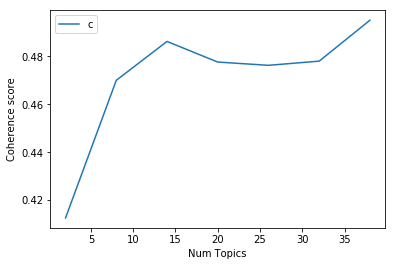

In [27]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()